This notebook introduces flexible preprocessing pipelines with MONAI, using the following components:

- Dictionary transforms
- Preprocessing with GPU caching and acceleration
- Persistent-cache dataset, thread-based data loader
- MetaTensor to track the applied operations
- Inversing a composed transform

In [ ]:
!python -c "import monai" || pip install "monai[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib

In [2]:
import monai
import monai.transforms as mt

import numpy as np
from glob import glob
from pprint import pprint
import matplotlib.pyplot as plt

# Making a synthetic example

## Generating image and segmentation pairs

5 single-channel images and labels in size 64x64x64, saving to the current directory in the NIfTI format.

In [3]:
print("generating synthetic data to the current directory (this may take a while)")
img_saver = mt.SaveImage(output_dir="./", output_postfix="img", separate_folder=False)
seg_saver = mt.SaveImage(output_dir="./", output_postfix="seg", separate_folder=False)

for i in range(5):
    im, seg = monai.data.create_test_image_3d(
        64, 64, 64, rad_max=10, rad_min=8, num_seg_classes=1, noise_max=0.5,
        channel_dim=0, random_state=np.random.RandomState(i))
    print("image", im.shape, "seg", seg.shape)
    img_saver(im)
    seg_saver(seg)

generating synthetic data to the current directory (this may take a while)
image (1, 64, 64, 64) seg (1, 64, 64, 64)
2022-09-21 08:38:33,959 INFO image_writer.py:194 - writing: 0_img.nii.gz
2022-09-21 08:38:34,039 INFO image_writer.py:194 - writing: 0_seg.nii.gz
image (1, 64, 64, 64) seg (1, 64, 64, 64)
2022-09-21 08:38:34,084 INFO image_writer.py:194 - writing: 1_img.nii.gz
2022-09-21 08:38:34,160 INFO image_writer.py:194 - writing: 1_seg.nii.gz
image (1, 64, 64, 64) seg (1, 64, 64, 64)
2022-09-21 08:38:34,204 INFO image_writer.py:194 - writing: 2_img.nii.gz
2022-09-21 08:38:34,296 INFO image_writer.py:194 - writing: 2_seg.nii.gz
image (1, 64, 64, 64) seg (1, 64, 64, 64)
2022-09-21 08:38:34,339 INFO image_writer.py:194 - writing: 3_img.nii.gz
2022-09-21 08:38:34,408 INFO image_writer.py:194 - writing: 3_seg.nii.gz
image (1, 64, 64, 64) seg (1, 64, 64, 64)
2022-09-21 08:38:34,457 INFO image_writer.py:194 - writing: 4_img.nii.gz
2022-09-21 08:38:34,526 INFO image_writer.py:194 - writing

## A list of data dictionaries
This is a typical data structure that the preprocessing pipeline works with.


In [4]:
imgs = sorted(glob("?_img.nii.gz"))
segs = sorted(glob("?_seg.nii.gz"))
train_files = [{"img": img, "seg": seg} for img, seg in zip(imgs, segs)]
pprint(train_files)

[{'img': '0_img.nii.gz', 'seg': '0_seg.nii.gz'},
 {'img': '1_img.nii.gz', 'seg': '1_seg.nii.gz'},
 {'img': '2_img.nii.gz', 'seg': '2_seg.nii.gz'},
 {'img': '3_img.nii.gz', 'seg': '3_seg.nii.gz'},
 {'img': '4_img.nii.gz', 'seg': '4_seg.nii.gz'}]


## Visualize the volumes

Images contain spheres with different intensity values, and noise sampled uniformly from [0, 0.5].

Labels are voxel-wise binary segmentations, yellow denotes the foreground, dark blue the background.

`monai.visualize.matshow3d` displays the image volumes as 2D slices.

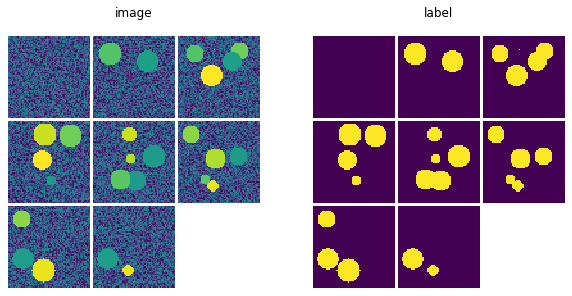

In [5]:
transform = mt.LoadImageD(("img", "seg"), ensure_channel_first=True, image_only=True)
dataset = monai.data.Dataset(train_files, transform=transform)
img_seg = dataset[0]

fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
fig_img = monai.visualize.matshow3d(img_seg["img"], title="image", fig=plt.gca(), every_n=8)
plt.subplot(1, 2, 2)
fig_seg = monai.visualize.matshow3d(img_seg["seg"], title="label", fig=plt.gca(), every_n=8)

In this section, we have generated 5 pairs of image and voxel-wise segmenetation map as NIfTI files.

The filenames are stored in the `train_files` variable.

# Compose the transforms

The following commands sample image patches from the synthetic datasets.
Key features:
- Same set of (randomized) transforms applied to both 'img' and 'seg'
- Each patch has the metadata tracking the parameters of the transforms
- Transforms support MetaTensors on CPU and GPU devices
- Utilities such as `DataStatsD` help debugging

In [20]:
keys = ("img", "seg")
t = mt.Compose([
    mt.LoadImageD(keys, image_only=True),
    mt.EnsureChannelFirstD(keys),
    mt.OrientationD(keys, "RAS"),
    mt.CropForegroundD(keys, source_key="seg"),
    mt.ScaleIntensityRangePercentilesD("img", 5, 95, b_min=0.01, b_max=1.0, clip=True),
    mt.SpacingD(keys, pixdim=[1.2, 1.5, 1.5], mode=("bilinear", "nearest")),
    mt.DataStatsD(keys),  # this transform shows input data properties for debugging
    mt.DivisiblePadD(keys, 7, mode="replicate"),
    # pre-compute foreground and background indexes
    # and cache them to accelerate training
    mt.FgBgToIndicesD(keys="seg", fg_postfix="_fg", bg_postfix="_bg"),
    # move the data to GPU and cache to avoid CPU -> GPU sync in every epoch
    mt.ToDeviceD(keys=keys, device="cuda:0"),
    # randomly crop out patch samples from big
    # image based on pos / neg ratio
    # the image centers of negative samples
    # must be in valid image area
    mt.RandCropByPosNegLabelD(
        keys=keys,
        label_key="seg",
        spatial_size=(15, 15, 15),
        pos=2,
        neg=1,
        num_samples=4,
        fg_indices_key="seg_fg",
        bg_indices_key="seg_bg",
    ),
    mt.RandAffineD(keys, prob=1.0, rotate_range=(0.5, 0.5, 0.5),
                   scale_range=(0.1, 0.1, 0.1), mode=("bilinear", "nearest")),
])

The preprocessing steps with MONAI's dataset and loader.

Key features:
- Datasets with persistent cache to accerlerate repeated preprocessing steps during training
- MONAI's `list_data_collate` function as an extension of PyTorch `default_collate`
- MONAI's `worker_init_fn` and `Randomizable` API handles the determinism
- "decollating" mini-batch so that each data item of a mini-batch can be postprocessed independently

In [23]:
monai.utils.set_determinism(2022)

dataset = monai.data.CacheDataset(train_files, t, cache_rate=1.0, copy_cache=False)
batch_loader = monai.data.ThreadDataLoader(dataset, num_workers=0, batch_size=2, shuffle=True)

batch = monai.utils.first(batch_loader)
print("batch shape", batch["seg"].shape)
for x in batch_loader:
    print("batch shape", x["seg"].shape)

batch shape (8, 1, 15, 15, 15)
batch shape (8, 1, 15, 15, 15)
batch shape (8, 1, 15, 15, 15)
batch shape (4, 1, 15, 15, 15)


The following cell visualizes the first batch as an example.

Note the ratio of foreground vs background patches roughly matches the value set in `RandCropByPosNegLabelD`.

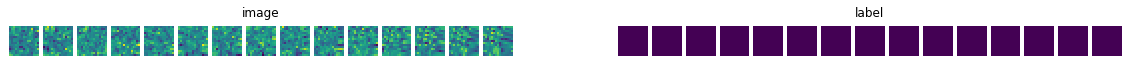

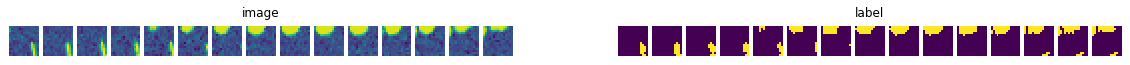

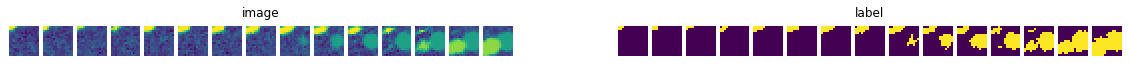

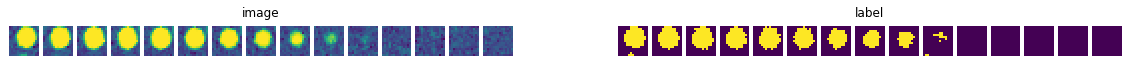

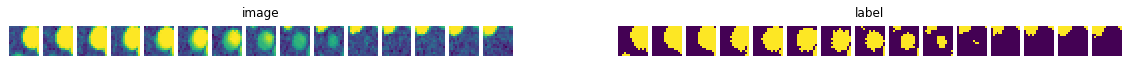

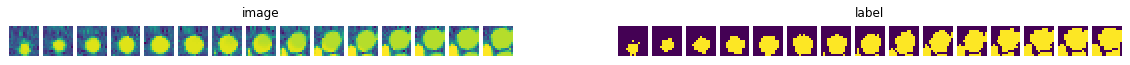

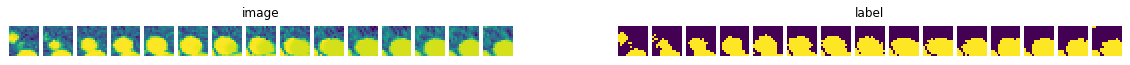

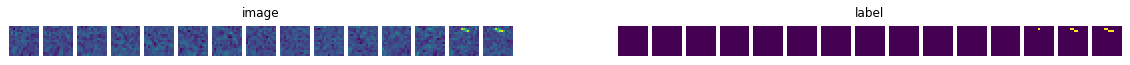

In [24]:
for item in zip(batch["img"], batch["seg"]):
    fig = plt.figure(figsize=(20, 30))
    plt.subplot(1, 2, 1)
    fig_img = monai.visualize.matshow3d(item[0], title="image", fig=plt.gca(), frames_per_row=15)
    plt.subplot(1, 2, 2)
    fig_seg = monai.visualize.matshow3d(item[1], title="label", fig=plt.gca(), frames_per_row=15)

### Inspecting an image patch of the first mini-batch `batch["img"][4]`:

In [34]:
img_patch = batch["img"][4]
type(img_patch)

monai.data.meta_tensor.MetaTensor

In [35]:
img_patch.device

device(type='cuda', index=0)

In [39]:
print(img_patch.meta["filename_or_obj"])  # original image
print(img_patch.shape)
print(img_patch.affine)
print(img_patch.pixdim)

2_img.nii.gz
(1, 15, 15, 15)
tensor([[ 1.0585,  0.4884, -0.4300, 37.9815],
        [-0.8754,  0.9907, -0.6870, 33.0019],
        [ 0.0804,  0.7392,  1.3646, 22.7100],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)
tensor([1.3760, 1.3291, 1.5872], dtype=torch.float64)


In [37]:
pprint(img_patch.applied_operations)

[{class: 'Orientation',
  extra_info: {'original_affine': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])},
  id: none,
  orig_size: [64, 64, 64]},
 {class: 'CropForeground',
  extra_info: {'cropped': [5, 2, 5, 5, 5, 7],
               'pad_info': {class: 'Pad',
                            extra_info: {'padded': [[0, 0],
                                                    [0, 0],
                                                    [0, 0],
                                                    [0, 0]]},
                            id: none,
                            orig_size: [57, 54, 52]}},
  id: none,
  orig_size: [64, 64, 64]},
 {class: 'SpatialResample',
  extra_info: {'align_corners': False,
               'dtype': 'float64',
               'mode': 'bilinear',
               'padding_mode': 'border',
               'src_affine': tensor([[1., 0., 0., 5.],
        [0., 1., 0., 5.],
        [0., 0., 1., 5.],
        [0., 0., 0., 1.]

### Write the image patch and visualize with an external NIfTI viewer

In [38]:
output = mt.SaveImage(resample=False)(img_patch)

2022-09-21 08:51:09,349 INFO image_writer.py:194 - writing: 2_img/2_img_trans_0.nii.gz


The following figures show:
- slices of the original input image (in gray scale), and 
- the image patch `2_img_trans_0.nii.gz` in the original image space.

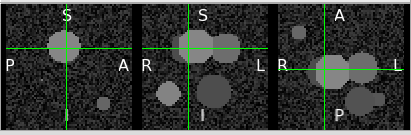

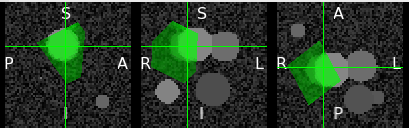

# Example of inverting a composed transform


In [13]:
monai.utils.set_determinism(2022)
keys = ("img", "seg")
t = mt.Compose([
    mt.LoadImageD(keys, image_only=True),
    mt.EnsureChannelFirstD(keys),
    mt.OrientationD(keys, "RAS"),
    mt.CropForegroundD(keys, source_key="seg"),
    mt.ScaleIntensityRangePercentilesD("img", 5, 95, b_min=0.01, b_max=1.0, clip=True),
    mt.SpacingD(keys, pixdim=[1.2, 1.5, 1.5], mode=("bilinear", "nearest")),
    mt.DivisiblePadD(keys, 7, mode="replicate"),
    mt.ToDeviceD(keys=keys, device="cuda:0"),
    mt.RandAffineD(keys, prob=1.0, spatial_size=(32, 32, 32),
                   rotate_range=(0.5, 0.5, 0.5),
                   scale_range=(0.1, 0.1, 0.1), mode=("bilinear", "nearest")),
])

## Run the preprocessing steps

Construct the loading pipeline, and fetch the first batch as an example.

In [14]:
dataset = monai.data.PersistentDataset(train_files, t, cache_dir="./cache", hash_transform=monai.data.json_hashing)
batch_loader = monai.data.ThreadDataLoader(dataset, num_workers=0, batch_size=2, shuffle=True)

batch = monai.utils.first(batch_loader)

## Visualize the transformed samples

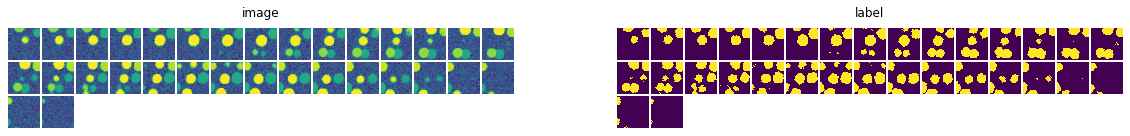

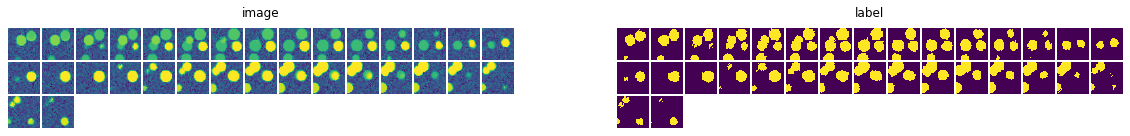

In [15]:
for item in zip(batch["img"], batch["seg"]):
    fig = plt.figure(figsize=(20, 30))
    plt.subplot(1, 2, 1)
    fig_img = monai.visualize.matshow3d(item[0], title="image", fig=plt.gca(), frames_per_row=15)
    plt.subplot(1, 2, 2)
    fig_seg = monai.visualize.matshow3d(item[1], title="label", fig=plt.gca(), frames_per_row=15)

## Invert the preprocessing steps

- Requires both the transform `t` and a dictionary of MetaTensor `{"img": item}`
- `item.applied_operations` have the tracked transform information
- `convert_applied_interp_mode` can override the interpolation mode of the inversion

In [16]:
output_batch = batch["img"] + 0.5   # this is to simulate a fully-conv. net inference on batch['img']

for idx, item in enumerate(output_batch):
    if not isinstance(item, monai.data.MetaTensor):
        item = monai.data.MetaTensor(item)
    item.applied_operations = batch["img"][idx].applied_operations
    mt.utils.convert_applied_interp_mode(item.applied_operations, mode="bilinear")
    with mt.allow_missing_keys_mode(t):
        inverted = t.inverse({"img": item})

The `inverted["img"]` is now an image patch inverted to the original image space. This is useful when the pipeline outcomes are sensitive to spatial transforms, e.g., for computing evaluation metrics, test-time augmentations.

## Compare the inverted results with the original input images
Some of the transforms are lossy, the inverted only partly matches the original inputs.

In [17]:
original_filename = inverted["img"].meta["filename_or_obj"]
print("original filename:", original_filename)

original filename: 2_img.nii.gz


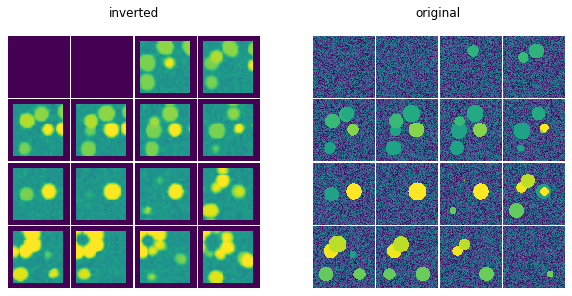

In [18]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
fig_img = monai.visualize.matshow3d(inverted["img"], title="inverted", fig=plt.gca(), every_n=4)
plt.subplot(1, 2, 2)
original_img = mt.LoadImage(image_only=True)(original_filename)
fig_seg = monai.visualize.matshow3d(original_img, title="original", fig=plt.gca(), every_n=4)

For more information about different sampling strategies for 2D slices from 3D images, please see also:
- `PatchDataset` -- when # slices per volume is predefined: https://github.com/Project-MONAI/tutorials/blob/main/modules/2d_slices_from_3d_sampling.ipynb
- `PatchIterd` -- when varying # slices are sampled from the voulumes https://github.com/Project-MONAI/tutorials/blob/main/modules/2d_inference_3d_volume.ipynb
- Slicing window inferences (2D model scanning through 3D input) https://github.com/Project-MONAI/tutorials/blob/main/modules/2d_slices_from_3d_training.ipynb